In this analysis, it was used the data made available by the **Infodengue** (https://info.dengue.mat.br/) . It was used the data until the end of the 2017 year for the Fortaleza city city. 

The data is saved in the data folder. It was named as: `{disease}_{ibge_code}.csv` and assigned with `cluster` in the end when it refers to the clustered data. 

Let's look at the dengue and chik data for this case. Note that we have some statistics related to humidity, temperature, and the number of cases. These features will be used to forecast the number of dengue cases reported. 

In [1]:
import os 
import pickle
os.chdir('../')
import pandas as pd
from datetime import datetime
from pgbm import qf_prediction
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from pgbm import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2304400
CITY_NAME = 'Fortaleza'
STATE = 'CE'
END_DATE = '2016-01-01' # assign the last day used to train the dengue model 
INI_DATE_CHIK = END_DATE # assign the first day used to retrain the model with chik data 
END_TRAIN_CHIK = '2016-05-01' # assign the last day used to retrain the model with chik data
END_DATE_CHIK = '2017-01-01' # assign the last day of chik data used to apply the trained model 
INI_EVALUATE = '2016-05-01' # assign the first day used to evaluate the trained model (transfer learning)
END_EVALUATE = '2016-06-05' # assign the last day used to evaluate the trained model (transfer learning)
PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 

In [3]:
df_dengue = pd.read_csv(f'./data/dengue_{CITY}.csv', index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2304400,casos_est_2304400,casos_est_min_2304400,casos_est_max_2304400,p_rt1_2304400,p_inc100k_2304400,temp_min_2304400,temp_max_2304400,umid_min_2304400,pressao_min_2304400
2010-01-03,56,56.0,56,56,0.000000,2.084410,23.333333,28.333333,66.333333,1009.000000
2010-01-10,55,55.0,55,55,0.000000,2.047188,24.714286,29.714286,59.571429,1009.428571
2010-01-17,77,77.0,77,77,0.000000,2.866063,25.142857,30.571429,58.142857,1010.714286
2010-01-24,56,56.0,56,56,0.000000,2.084410,24.714286,30.857143,54.142857,1009.000000
2010-01-31,114,114.0,114,114,0.000000,4.243262,24.714286,30.571429,61.428571,1007.857143
...,...,...,...,...,...,...,...,...,...,...
2022-06-05,1553,1711.0,1593,2050,0.050776,63.686160,23.857143,28.857143,72.411274,1009.857143
2022-06-12,1234,1445.0,1287,1906,0.000001,53.785213,23.857143,28.571429,71.832598,1010.857143
2022-06-19,778,1043.0,844,1779,0.000000,38.822130,24.571429,29.571429,61.422357,1012.000000
2022-06-26,294,646.0,363,1750,0.000000,24.045155,24.142857,28.857143,64.995621,1011.000000


Note that the chik dataset has the same columns

In [4]:
df_chik = pd.read_csv(f'./data/chik_{CITY}.csv', index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2304400,casos_est_2304400,casos_est_min_2304400,casos_est_max_2304400,p_rt1_2304400,p_inc100k_2304400,temp_min_2304400,temp_max_2304400,umid_min_2304400,pressao_min_2304400
2010-01-03,0,0.0,0,0,0.000000e+00,0.000000,23.333333,28.333333,66.333333,1009.000000
2010-01-10,0,0.0,0,0,0.000000e+00,0.000000,24.714286,29.714286,59.571429,1009.428571
2010-01-17,0,0.0,0,0,0.000000e+00,0.000000,25.142857,30.571429,58.142857,1010.714286
2010-01-24,0,0.0,0,0,0.000000e+00,0.000000,24.714286,30.857143,54.142857,1009.000000
2010-01-31,0,0.0,0,0,0.000000e+00,0.000000,24.714286,30.571429,61.428571,1007.857143
...,...,...,...,...,...,...,...,...,...,...
2022-06-05,1159,1442.0,1277,1774,2.059319e-11,53.673550,23.857143,28.857143,72.411274,1009.857143
2022-06-12,891,1250.5,1051,1654,9.992007e-16,46.545612,23.857143,28.571429,71.832598,1010.857143
2022-06-19,725,1142.0,915,1587,4.315481e-11,42.507070,24.571429,29.571429,61.422357,1012.000000
2022-06-26,246,724.0,435,1415,0.000000e+00,26.948439,24.142857,28.857143,64.995621,1011.000000


The main difference between the datasets above and the datasets with names ended with `cluster` is the number of columns. This dataset has columns with data from other cities. The city is identified by a 7-number code. These cities was clusterized with Fortaleza (in this case) using a hierarchical clusterization algorithm. 

In [5]:
df_chik_cluster = pd.read_csv(f'./data/chik_{CITY}_cluster.csv', index_col = 'Unnamed: 0' )
df_chik_cluster.index = pd.to_datetime(df_chik_cluster.index)
df_chik_cluster

,casos_2304400,casos_est_2304400,casos_est_min_2304400,casos_est_max_2304400,p_rt1_2304400,p_inc100k_2304400,temp_min_2304400,temp_max_2304400,umid_min_2304400,pressao_min_2304400,...,casos_2306306,casos_est_2306306,casos_est_min_2306306,casos_est_max_2306306,p_rt1_2306306,p_inc100k_2306306,temp_min_2306306,temp_max_2306306,umid_min_2306306,pressao_min_2306306
2010-01-03,0,0.0,0,0,0.000000e+00,0.000000,23.333333,28.333333,66.333333,1009.000000,...,0,0.0,0,0,0.0,0.0,23.333333,28.333333,66.333333,1009.000000
2010-01-10,0,0.0,0,0,0.000000e+00,0.000000,24.714286,29.714286,59.571429,1009.428571,...,0,0.0,0,0,0.0,0.0,24.714286,29.714286,59.571429,1009.428571
2010-01-17,0,0.0,0,0,0.000000e+00,0.000000,25.142857,30.571429,58.142857,1010.714286,...,0,0.0,0,0,0.0,0.0,25.142857,30.571429,58.142857,1010.714286
2010-01-24,0,0.0,0,0,0.000000e+00,0.000000,24.714286,30.857143,54.142857,1009.000000,...,0,0.0,0,0,0.0,0.0,24.714286,30.857143,54.142857,1009.000000
2010-01-31,0,0.0,0,0,0.000000e+00,0.000000,24.714286,30.571429,61.428571,1007.857143,...,0,0.0,0,0,0.0,0.0,24.714286,30.571429,61.428571,1007.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05,1159,1442.0,1277,1774,2.059319e-11,53.673550,23.857143,28.857143,72.411274,1009.857143,...,0,0.0,0,0,0.0,0.0,23.857143,28.857143,72.411274,1009.857143
2022-06-12,891,1250.5,1051,1654,9.992007e-16,46.545612,23.857143,28.571429,71.832598,1010.857143,...,0,0.0,0,0,0.0,0.0,23.857143,28.571429,71.832598,1010.857143
2022-06-19,725,1142.0,915,1587,4.315481e-11,42.507070,24.571429,29.571429,61.422357,1012.000000,...,0,0.0,0,0,0.0,0.0,24.571429,29.571429,61.422357,1012.000000
2022-06-26,246,724.0,435,1415,0.000000e+00,26.948439,24.142857,28.857143,64.995621,1011.000000,...,0,0.0,0,0,0.0,0.0,24.142857,28.857143,64.995621,1011.000000


We need to have this kind of data because, in our tests, the gradient boosting tree model perform betters when using the cluster data, while the neural network model performed better using only the city's data. 

Let's plot this two incidence curver (dengue and chik):

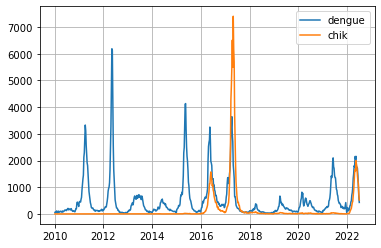

In [6]:
fig, ax = plt.subplots()

ax.plot(df_dengue[f'casos_est_{CITY}'], label = 'dengue')

ax.plot(df_chik[f'casos_est_{CITY}'], label = 'chik')

plt.legend()
plt.grid()
plt.show()

### Neural network model (NN)

First, we make the prediction using the data up to 2016-01-01 and use 25% data to test the model. It used 25% of the training data as validation data. It used the early stop config to train the model faster to monitor the loss function. 

Before applying the nn model we compute the first derivative of our target (the incidence curve) and added it as a feature. 

The neural newtork model is constructed using the `build_model` function. This function create a model with a bidirectional LSTM layer and a simple LSTM layer. We use the last 4 (look_back parameter) observations to predict the next 4 (predict_n parameter). 

The predictions of this models are saved in the path:
'./predictions/lstm/lstm_{city}_dengue_{label}.pkl'

The model is saved in the path: 
'./saved_models/lstm/trained_{geocode}_model_{label}.h5'

2022-08-30 23:35:15.483727: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 23:35:15.485187: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Compilation Time :  0.03183889389038086
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
___________________

2022-08-30 23:35:20.486316: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


172/172 [==============================] - 7s 43ms/sample - loss: 0.0160 - accuracy: 0.2674 - mape: 192.2607 - mse: 0.0274 - val_loss: 0.0022 - val_accuracy: 0.2241 - val_mape: 215.3161 - val_mse: 0.0024
Epoch 2/100
172/172 [==============================] - 2s 13ms/sample - loss: 0.0119 - accuracy: 0.2791 - mape: 224.4343 - mse: 0.0215 - val_loss: 0.0020 - val_accuracy: 0.2241 - val_mape: 168.1720 - val_mse: 0.0023
Epoch 3/100
172/172 [==============================] - 3s 15ms/sample - loss: 0.0069 - accuracy: 0.2442 - mape: 114.6808 - mse: 0.0136 - val_loss: 9.4173e-04 - val_accuracy: 0.2069 - val_mape: 84.9067 - val_mse: 0.0010
Epoch 4/100
172/172 [==============================] - 2s 13ms/sample - loss: 0.0050 - accuracy: 0.3198 - mape: 91.9948 - mse: 0.0102 - val_loss: 0.0011 - val_accuracy: 0.3621 - val_mape: 73.4837 - val_mse: 0.0013
Epoch 5/100
172/172 [==============================] - 3s 15ms/sample - loss: 0.0055 - accuracy: 0.3198 - mape: 88.3149 - mse: 0.0108 - val_loss: 0

172/172 [==============================] - 10s 61ms/sample - loss: 0.0025 - accuracy: 0.4767 - mape: 71.7956 - mse: 0.0053 - val_loss: 0.0017 - val_accuracy: 0.3103 - val_mape: 112.5276 - val_mse: 0.0021
Epoch 39/100
172/172 [==============================] - 8s 47ms/sample - loss: 0.0021 - accuracy: 0.4302 - mape: 80.4943 - mse: 0.0044 - val_loss: 0.0012 - val_accuracy: 0.2759 - val_mape: 83.0437 - val_mse: 0.0014
Epoch 40/100
172/172 [==============================] - 18s 104ms/sample - loss: 0.0026 - accuracy: 0.4477 - mape: 76.3464 - mse: 0.0056 - val_loss: 8.2303e-04 - val_accuracy: 0.3276 - val_mape: 65.6317 - val_mse: 9.5332e-04
Epoch 41/100
172/172 [==============================] - 13s 74ms/sample - loss: 0.0022 - accuracy: 0.4128 - mape: 85.1456 - mse: 0.0041 - val_loss: 5.7906e-04 - val_accuracy: 0.2759 - val_mape: 76.1879 - val_mse: 6.5745e-04
Epoch 42/100
172/172 [==============================] - 9s 54ms/sample - loss: 0.0028 - accuracy: 0.4535 - mape: 80.3377 - mse: 0.00

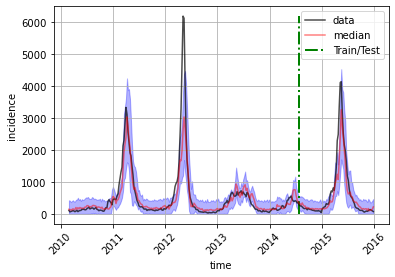

CPU times: user 11min 52s, sys: 1min 5s, total: 12min 57s
Wall time: 8min 37s


,0,1,2,3
mean_absolute_error,96.857009,117.834748,141.364641,180.351775
explained_variance_score,0.949910,0.901261,0.851115,0.784674
mean_squared_error,41042.299537,82865.837756,124647.445554,176473.105574
mean_squared_log_error,0.160180,0.133102,0.153933,0.255194
median_absolute_error,50.279690,43.819132,48.969321,79.460150
r2_score,0.948568,0.896131,0.843752,0.778775


In [7]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 0.75, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle')

### PGBM model (ml) 

In this case, we use the last 4 observations to predict the next 4. Since a GBT (gradient boosting tree) model has a 1D target, we trained four different models each one specialized in predicting one of the next four observations.

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_{doenca}_predictions.pkl'

The models are saved in the path:
'./saved_models/pgbm/{city}_{doenca}_city_model_{d}_pgbm.pt'
where d is in the arange 1 to 4. 


/opt/anaconda3/envs/alerta_dengue/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 803.1504
Estimator 1/100, Train metric: 738.2855
Estimator 2/100, Train metric: 679.3170
Estimator 3/100, Train metric: 625.2888
Estimator 4/100, Train metric: 575.8366
Estimator 5/100, Train metric: 531.1493
Estimator 6/100, Train metric: 490.1667
Estimator 7/100, Train metric: 452.8211
Estimator 8/100, Train metric: 418.6571
Estimator 9/100, Train metric: 386.6302
Estimator 10/100, Train metric: 357.5076
Estimator 11/100, Train metric: 330.8830
Estimator 12/100, Train metric: 306.8415
Estimator 13/100, Train metric: 284.2687
Estimator 14/100, Train metric: 263.7117
Estimator 15/100, Train metric: 245.2244
Estimator 16/100, Train metric: 228.3346
Estimator 17/100, Train metric: 212.8035
Estimator 18/100, Train metric: 198.4922
Estimator 19/100, Train metric: 185.5836
Estimator 20/100, Train metric: 174.0092
Estimator 21/100, Train metric: 162.8460
Estimator 22/100, Train metric: 152.6462
Estimator 23/100, Train metric: 143.3440
Estimator 24/100, Train me

Estimator 4/100, Train metric: 579.9850
Estimator 5/100, Train metric: 536.0485
Estimator 6/100, Train metric: 496.0938
Estimator 7/100, Train metric: 460.1428
Estimator 8/100, Train metric: 427.1992
Estimator 9/100, Train metric: 397.0184
Estimator 10/100, Train metric: 368.5239
Estimator 11/100, Train metric: 341.0279
Estimator 12/100, Train metric: 316.2029
Estimator 13/100, Train metric: 293.0552
Estimator 14/100, Train metric: 272.9304
Estimator 15/100, Train metric: 253.2357
Estimator 16/100, Train metric: 235.0543
Estimator 17/100, Train metric: 218.5801
Estimator 18/100, Train metric: 203.6121
Estimator 19/100, Train metric: 189.9337
Estimator 20/100, Train metric: 178.1720
Estimator 21/100, Train metric: 166.3777
Estimator 22/100, Train metric: 156.6750
Estimator 23/100, Train metric: 146.5559
Estimator 24/100, Train metric: 138.2145
Estimator 25/100, Train metric: 130.7259
Estimator 26/100, Train metric: 122.6691
Estimator 27/100, Train metric: 116.4647
Estimator 28/100, Trai

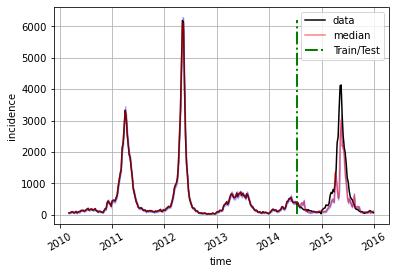

CPU times: user 4min 7s, sys: 32.1 s, total: 4min 39s
Wall time: 54.2 s


In [8]:
%%time

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE)
   

### Comparing the Neural and ML model 

In this section we compare the performance of the ML and NN model. 

In [9]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_msle.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_{doenca}_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

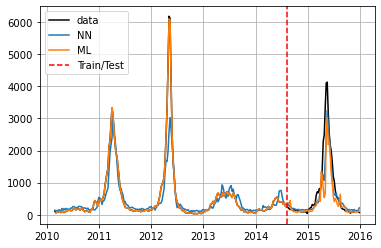

In [10]:
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.axvline(data_ml['dates'][data_ml['train_size']], color = 'red', ls = '--', label = 'Train/Test') # refered to the ML model 

plt.grid()
plt.legend()
plt.show()

Let's compare the error of this models in the test data: 

In [11]:
print('NN error (RMSE):', mse(data_nn['target'][data_nn['xdata'].shape[0]:, -1] * data_nn['factor'], data_nn['pred'].iloc[data_nn['xdata'].shape[0]:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4+ data_ml['train_size']:], data_ml['preds'][data_ml['train_size']:], squared = False))

NN error (RMSE): 392.63949557736294
ML error (RMSE): 536.570677880114


Looking at the error above we can see that besides comsume more time training, the neural network model (nn) outperform the machine learning model (ml)

We will know use this models to predict the chik outbreak in 2016. In order to do this, we will retrain the nn model and the ml model using the dengue data up to '2016-01-01' and apply the model in the chik data between '2016-01-01' and '2017-01-01'

The label parameter is used as a flag to make difference, if necessary, between the models saved, since this model takes a lot of time to be trained


Compilation Time :  0.031430721282958984
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
________________

2022-08-30 23:44:52.559457: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


228/228 [==============================] - 8s 37ms/sample - loss: 0.0118 - accuracy: 0.2939 - mape: 179.3372 - mse: 0.0202 - val_loss: 0.0117 - val_accuracy: 0.2078 - val_mape: 205.6998 - val_mse: 0.0189
Epoch 2/100
228/228 [==============================] - 3s 13ms/sample - loss: 0.0081 - accuracy: 0.2763 - mape: 157.5296 - mse: 0.0148 - val_loss: 0.0048 - val_accuracy: 0.2338 - val_mape: 70.9805 - val_mse: 0.0085
Epoch 3/100
228/228 [==============================] - 3s 13ms/sample - loss: 0.0054 - accuracy: 0.3465 - mape: 103.8180 - mse: 0.0104 - val_loss: 0.0032 - val_accuracy: 0.2987 - val_mape: 85.6471 - val_mse: 0.0055
Epoch 4/100
228/228 [==============================] - 7s 32ms/sample - loss: 0.0042 - accuracy: 0.2982 - mape: 85.8863 - mse: 0.0080 - val_loss: 0.0040 - val_accuracy: 0.2857 - val_mape: 58.8099 - val_mse: 0.0071
Epoch 5/100
228/228 [==============================] - 4s 16ms/sample - loss: 0.0039 - accuracy: 0.2982 - mape: 89.8092 - mse: 0.0074 - val_loss: 0.0035

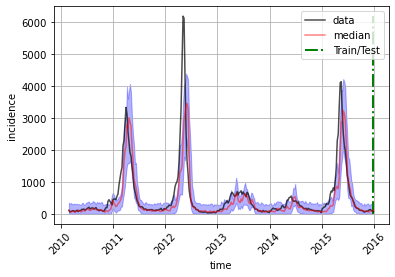

CPU times: user 4min 53s, sys: 18 s, total: 5min 11s
Wall time: 3min 2s


,0,1,2,3
mean_absolute_error,138.000865,153.372717,198.913094,228.873075
explained_variance_score,0.923631,0.902565,0.805841,0.660901
mean_squared_error,71031.251178,87281.182246,169661.513822,283838.666053
mean_squared_log_error,0.358099,0.597794,0.754468,0.293028
median_absolute_error,73.376354,77.452009,80.417726,51.822995
r2_score,0.910987,0.890596,0.787325,0.644182


In [12]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back= LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'msle_all')

Estimator 0/100, Train metric: 815.6866
Estimator 1/100, Train metric: 747.2837
Estimator 2/100, Train metric: 685.0117
Estimator 3/100, Train metric: 628.7183
Estimator 4/100, Train metric: 577.4652
Estimator 5/100, Train metric: 530.6690
Estimator 6/100, Train metric: 488.3899
Estimator 7/100, Train metric: 449.9754
Estimator 8/100, Train metric: 414.4475
Estimator 9/100, Train metric: 382.3337
Estimator 10/100, Train metric: 353.0159
Estimator 11/100, Train metric: 326.4021
Estimator 12/100, Train metric: 301.7664
Estimator 13/100, Train metric: 279.2392
Estimator 14/100, Train metric: 258.6008
Estimator 15/100, Train metric: 239.7266
Estimator 16/100, Train metric: 222.4630
Estimator 17/100, Train metric: 206.7503
Estimator 18/100, Train metric: 192.2728
Estimator 19/100, Train metric: 179.0781
Estimator 20/100, Train metric: 166.9967
Estimator 21/100, Train metric: 155.1056
Estimator 22/100, Train metric: 144.2483
Estimator 23/100, Train metric: 134.4718
Estimator 24/100, Train me

Estimator 6/100, Train metric: 494.1880
Estimator 7/100, Train metric: 455.4875
Estimator 8/100, Train metric: 421.3393
Estimator 9/100, Train metric: 388.7915
Estimator 10/100, Train metric: 359.4143
Estimator 11/100, Train metric: 333.0043
Estimator 12/100, Train metric: 309.1114
Estimator 13/100, Train metric: 287.2334
Estimator 14/100, Train metric: 267.3135
Estimator 15/100, Train metric: 248.7802
Estimator 16/100, Train metric: 232.1648
Estimator 17/100, Train metric: 216.6478
Estimator 18/100, Train metric: 202.9880
Estimator 19/100, Train metric: 187.8782
Estimator 20/100, Train metric: 175.2483
Estimator 21/100, Train metric: 164.0045
Estimator 22/100, Train metric: 153.4328
Estimator 23/100, Train metric: 143.8499
Estimator 24/100, Train metric: 135.1773
Estimator 25/100, Train metric: 126.4541
Estimator 26/100, Train metric: 118.9349
Estimator 27/100, Train metric: 112.2116
Estimator 28/100, Train metric: 105.3434
Estimator 29/100, Train metric: 99.6507
Estimator 30/100, Tra

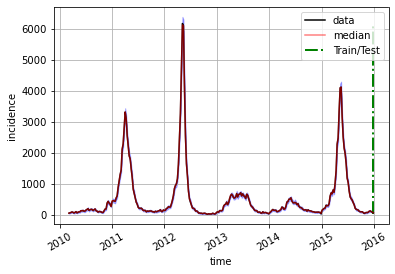

In [13]:

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE)
   

Apply the ml model in chik:

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl'

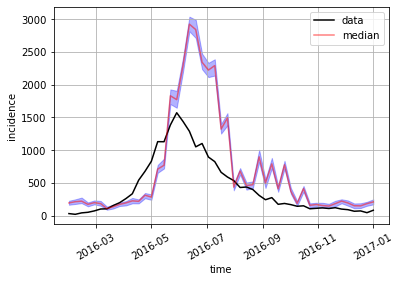

In [14]:

preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE_CHIK, end_date = END_DATE_CHIK)
    

Apply the NN model into the chik data:

The predictions is saved in the path: './predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl'

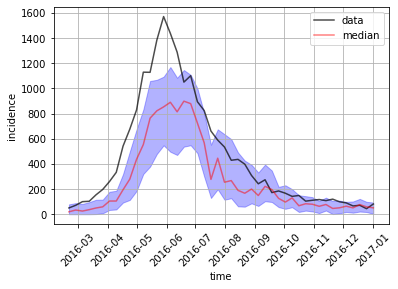

In [15]:

metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'msle_all' )

Compare the predictions:

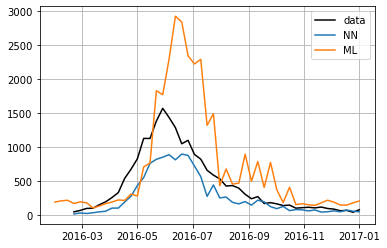

In [16]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.show()

Compute the RMSE error: 

In [17]:

print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 254.3579503866685
ML error (RMSE): 569.9867863049485


### Transfer learning 

Here we use the transfer learning technique to improve the performance of the predictions of the dengue model in the chik data. To do this, we retrain the output layer of the dengue model, and after it, retrain the model (all the layers, that's the fine tunning step). In this step, we need to pay attention to overfitting. It can be necessary to decrease the learning rate. 

We use the transfer learning technique since it is not possible to train a good ml or nn model with few observations, as in the case of the  chik outbreak in Fortaleza in 2016. 

Compilation Time :  0.029154062271118164
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 36
Non-trainable params: 1,824
_______________

2022-08-30 23:48:38.377647: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


11/11 [==============================] - 4s 350ms/sample - loss: 0.0231 - accuracy: 0.7273 - mape: 92.2388 - mse: 0.0313
Epoch 2/100
11/11 [==============================] - 0s 12ms/sample - loss: 0.0212 - accuracy: 0.6364 - mape: 87.6681 - mse: 0.0291
Epoch 3/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.0203 - accuracy: 0.7273 - mape: 76.0267 - mse: 0.0280
Epoch 4/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.0190 - accuracy: 0.7273 - mape: 69.0969 - mse: 0.0266
Epoch 5/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.0171 - accuracy: 0.7273 - mape: 61.2235 - mse: 0.0243
Epoch 6/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.0156 - accuracy: 0.7273 - mape: 54.2072 - mse: 0.0224
Epoch 7/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.0148 - accuracy: 0.7273 - mape: 54.9007 - mse: 0.0215
Epoch 8/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.0137 - ac

11/11 [==============================] - 0s 12ms/sample - loss: 0.0014 - accuracy: 1.0000 - mape: 31.0518 - mse: 0.0023 
Epoch 63/100
11/11 [==============================] - 0s 12ms/sample - loss: 5.6513e-04 - accuracy: 1.0000 - mape: 30.9455 - mse: 8.6846e-04
Epoch 64/100
11/11 [==============================] - 0s 12ms/sample - loss: 6.3799e-04 - accuracy: 1.0000 - mape: 26.2716 - mse: 9.2751e-04
Epoch 65/100
11/11 [==============================] - 0s 12ms/sample - loss: 8.3356e-04 - accuracy: 1.0000 - mape: 51.8005 - mse: 0.0011
Epoch 66/100
11/11 [==============================] - 0s 12ms/sample - loss: 0.0010 - accuracy: 1.0000 - mape: 46.2267 - mse: 0.0015 
Epoch 67/100
11/11 [==============================] - 0s 12ms/sample - loss: 4.6717e-04 - accuracy: 1.0000 - mape: 25.0395 - mse: 7.3027e-04
Epoch 68/100
11/11 [==============================] - 0s 12ms/sample - loss: 6.6659e-04 - accuracy: 1.0000 - mape: 31.3596 - mse: 0.0010
Epoch 69/100
11/11 [============================

2022-08-30 23:48:54.562209: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


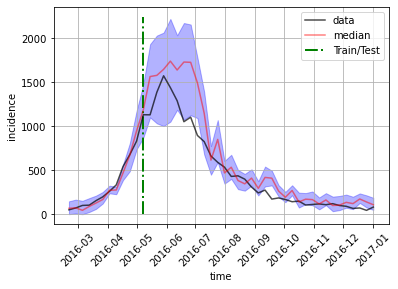

In [18]:
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'./saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs =100, features = 11,  
                            predict_n = 4, look_back = 4, loss = 'msle', validation_split = 0.0,
                            label = f'transf_chik')

To apply the transfer learning technique we use as train data the chik data up to '2016-05-01'. We can see that after this day the model has good performance considering the next month (data between '2016-05-01' and '2016-06-01'). 

To evaluate the improvement in the performance of the model we compute the following skill score: 

$$ SS = 1 - \cfrac{RMSE_{forecast}}{RMSE_{reference}}$$ 

In the formula, the reference represent the error of the model used as reference and the forecast represent the new model that we want to compare the performance. If the SS value is above 0 or new model is better than the reference model, otherwise it's worst. 

In [19]:
def ss(forecast, reference, target):
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)


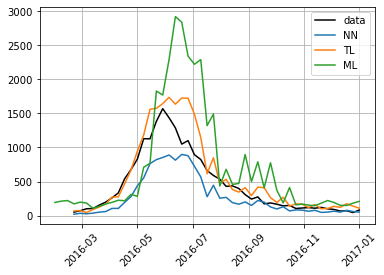

In [20]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [21]:
from datetime import datetime
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


SS compared to NN: 0.586815883388437
SS compared to ML: 0.45812481643832736


### Retrain the dengue model with a custom loss function 

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

This functions is defined as: 

```
def custom_loss_msle(p = 1):
    """
    :param p: 
    """
    
    def my_loss_msle(y_true, y_pred):
        """
        :param y_true:
        :param y_pred: 
        """

        def f1(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return tf.multiply(loss, p) 
        
        def f2(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return loss

        msle = tf.cond(tf.less(tf.gather(y_true, 0)[1],tf.gather(y_true, 0)[3]) , 
                                     true_fn = f1,
                                     false_fn = f2 )

        return tf.reduce_mean(msle) 
    
    return my_loss_msle 
```

In [22]:
from lstm import custom_loss_msle

Compilation Time :  0.03470921516418457
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
_________________

2022-08-30 23:49:18.125834: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


228/228 [==============================] - 9s 38ms/sample - loss: 0.0651 - accuracy: 0.3158 - mape: 170.2802 - mse: 0.0215 - val_loss: 0.0594 - val_accuracy: 0.2857 - val_mape: 211.0112 - val_mse: 0.0219
Epoch 2/100
228/228 [==============================] - 3s 13ms/sample - loss: 0.0552 - accuracy: 0.3158 - mape: 232.2092 - mse: 0.0188 - val_loss: 0.0610 - val_accuracy: 0.2597 - val_mape: 95.5721 - val_mse: 0.0205
Epoch 3/100
228/228 [==============================] - 3s 13ms/sample - loss: 0.0426 - accuracy: 0.3465 - mape: 133.2296 - mse: 0.0143 - val_loss: 0.0267 - val_accuracy: 0.2338 - val_mape: 92.2040 - val_mse: 0.0086
Epoch 4/100
228/228 [==============================] - 3s 13ms/sample - loss: 0.0262 - accuracy: 0.3684 - mape: 112.8096 - mse: 0.0097 - val_loss: 0.0167 - val_accuracy: 0.2987 - val_mape: 76.0592 - val_mse: 0.0052
Epoch 5/100
228/228 [==============================] - 12s 51ms/sample - loss: 0.0213 - accuracy: 0.3596 - mape: 95.8251 - mse: 0.0101 - val_loss: 0.01

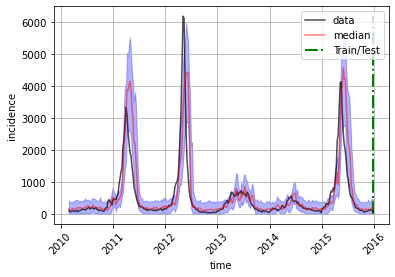

CPU times: user 10min 58s, sys: 44 s, total: 11min 42s
Wall time: 7min 57s


,0,1,2,3
mean_absolute_error,164.755241,141.974107,197.962506,279.293438
explained_variance_score,0.831538,0.866461,0.758149,0.528174
mean_squared_error,152294.328472,112895.570420,193055.413808,382976.387888
mean_squared_log_error,0.210859,0.165051,0.200738,0.306646
median_absolute_error,54.818117,51.326923,59.280329,75.923310
r2_score,0.809152,0.858490,0.758001,0.519904


In [23]:
%%time
model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back = LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1.0, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'custom_msle')

See the behaviour of this model when applied in the chik data:

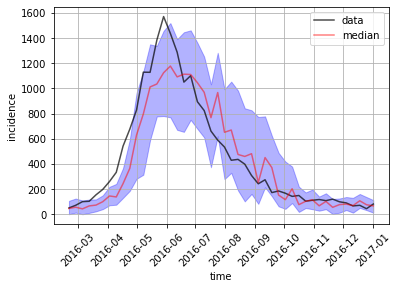

CPU times: user 22.1 s, sys: 1.98 s, total: 24.1 s
Wall time: 12.3 s


In [24]:
%%time
metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'custom_msle' )

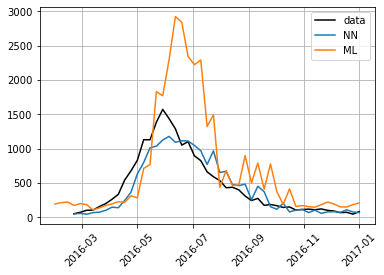

In [25]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [26]:
print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 164.90893404942454
ML error (RMSE): 569.9867863049485


Apply the transfer learning technique using this new trained model:

Compilation Time :  0.03676486015319824
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 36
Non-trainable params: 1,824
________________

2022-08-30 23:57:27.501981: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


11/11 [==============================] - 4s 361ms/sample - loss: 0.2255 - accuracy: 0.0909 - mape: 91.6503 - mse: 0.0306
Epoch 2/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.2139 - accuracy: 0.1818 - mape: 83.0152 - mse: 0.0293
Epoch 3/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.2056 - accuracy: 0.0000e+00 - mape: 75.3549 - mse: 0.0284
Epoch 4/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.1915 - accuracy: 0.0909 - mape: 66.4127 - mse: 0.0267
Epoch 5/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.1850 - accuracy: 0.3636 - mape: 60.9235 - mse: 0.0260
Epoch 6/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.1694 - accuracy: 0.2727 - mape: 54.3196 - mse: 0.0241
Epoch 7/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.1528 - accuracy: 0.4545 - mape: 52.9335 - mse: 0.0221
Epoch 8/100
11/11 [==============================] - 0s 11ms/sample - loss: 0.1420 

2022-08-30 23:57:39.857148: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


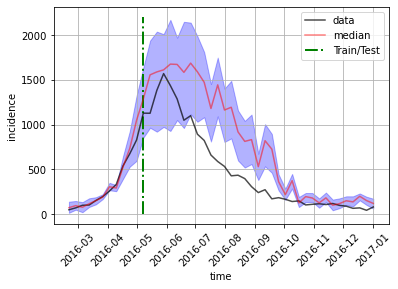

CPU times: user 58.8 s, sys: 4.79 s, total: 1min 3s
Wall time: 38.3 s


In [27]:
%%time
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'./saved_models/lstm/trained_{CITY}_model_custom_msle.h5',  epochs =100, features = 11,  
                            predict_n = PREDICT_N, look_back = LOOK_BACK, loss = custom_loss_msle(p=10), validation_split = 0.0,
                            label = f'transf_chik')

Comparing the predictions of the NN (neural network), the TL (transfer learning) and the ML (machine learning) model:

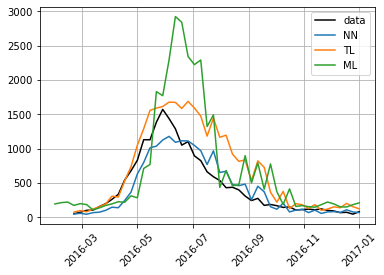

In [28]:
with open(f'./predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [29]:
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


SS compared to NN: 0.21070016238301614
SS compared to ML: 0.4014193145733229
